#### Import required libraries

In [175]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [176]:
# path = '/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/'
path = '/home/don/Git/aerial-semantic-segmentation/dataset_here/dataset/semantic_drone_dataset/'

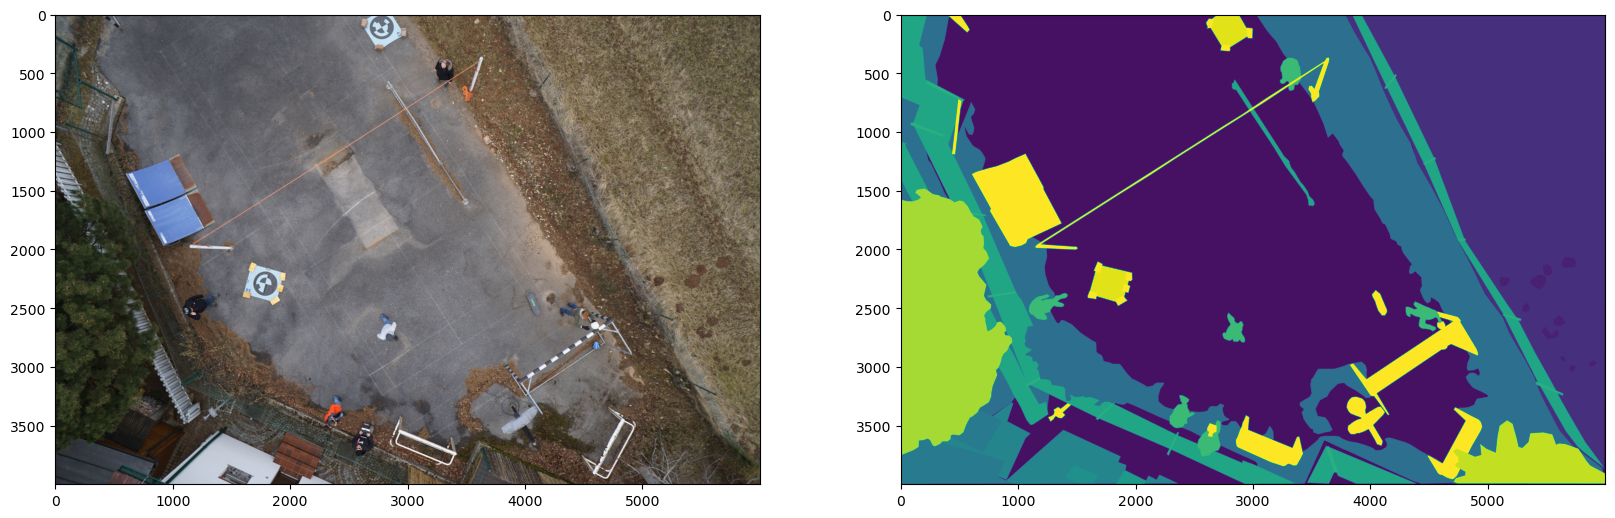

In [177]:
img = cv2.imread(path + 'original_images/001.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask_test = cv2.imread(path + 'label_images_semantic/001.png', cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(img)
axs[1].imshow(mask_test)

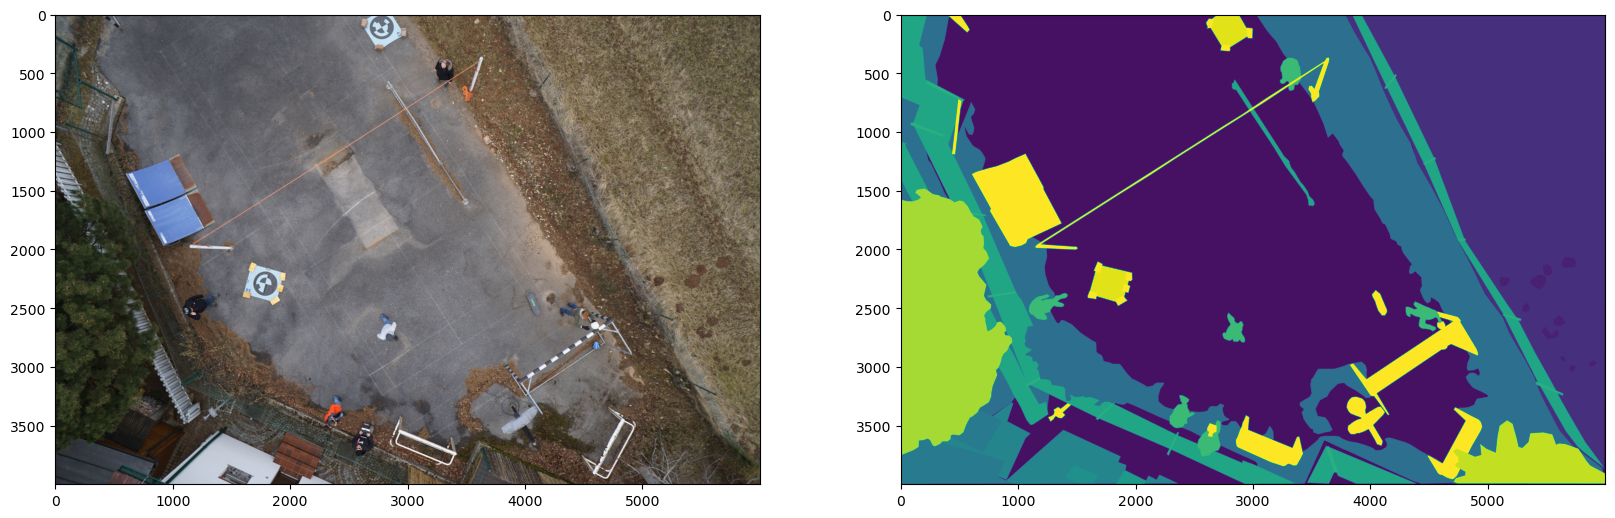

In [178]:
img = cv2.imread(path + 'original_images/001.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(path + 'label_images_semantic/001.png', cv2.IMREAD_GRAYSCALE)
#mask = mask.cvtColor(img, cv2.COLOR_BGR2RGB)
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(img)
axs[1].imshow(mask)

In [179]:
print('Image Dimensions are: ', img.shape)
print('Label Dimensions are: ', mask.shape)

Image Dimensions are:  (4000, 6000, 3)
Label Dimensions are:  (4000, 6000)


In [180]:
X = []
for filename in sorted(os.listdir(path + 'original_images/')):
    a = cv2.imread(path + 'original_images/' + filename)
    a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    a = cv2.resize(a, (128, 96))
    a = a / 255
    X.append(a)
    
X = np.array(X)

# Prepare the Labels
Y = []
for filename in sorted(os.listdir(path + 'label_images_semantic/')):
    a = cv2.imread(path + 'label_images_semantic/' + filename, cv2.IMREAD_GRAYSCALE)
    a = cv2.resize(a, (128, 96))
    #a = a / 255
    Y.append(a)
    
Y = np.array(Y)
#print(Y)
Yc = Y

(400, 96, 128, 3)
(400, 96, 128)


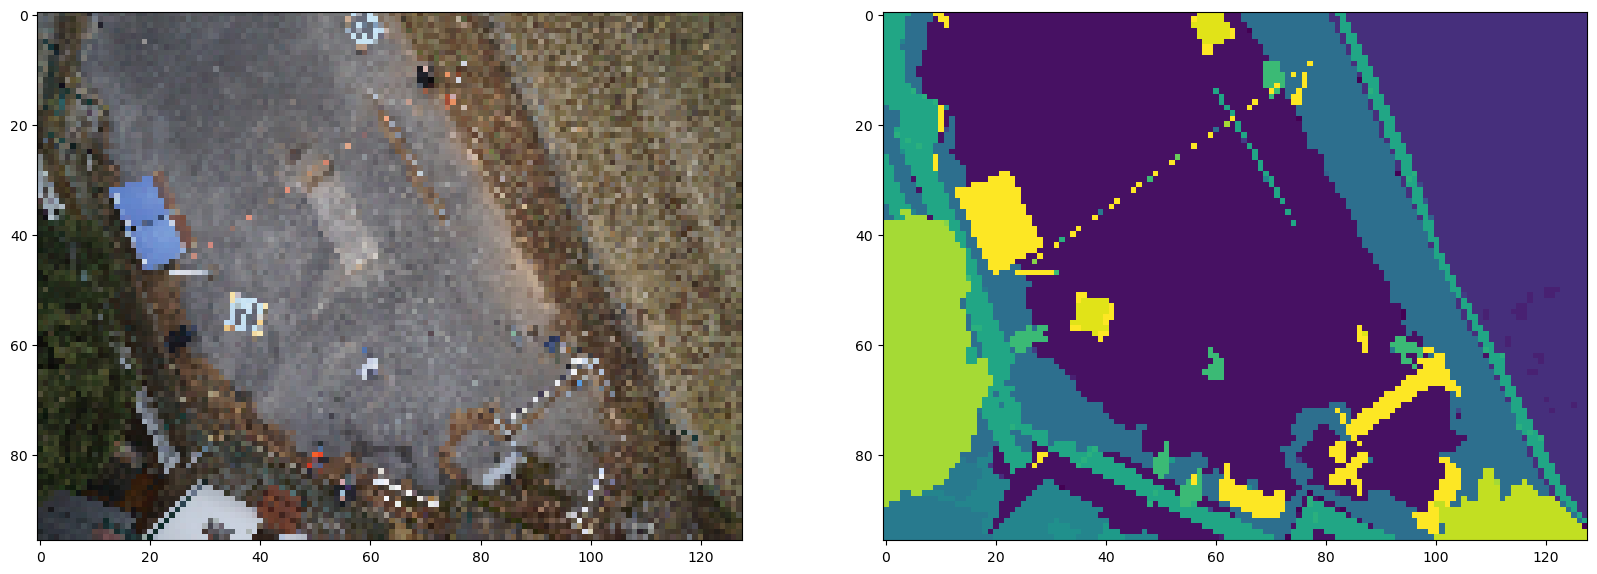

In [181]:
print(X.shape)
print(Y.shape)
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(X[1])
axs[1].imshow(Y[1])

(400, 96, 128, 3)
(400, 96, 128)


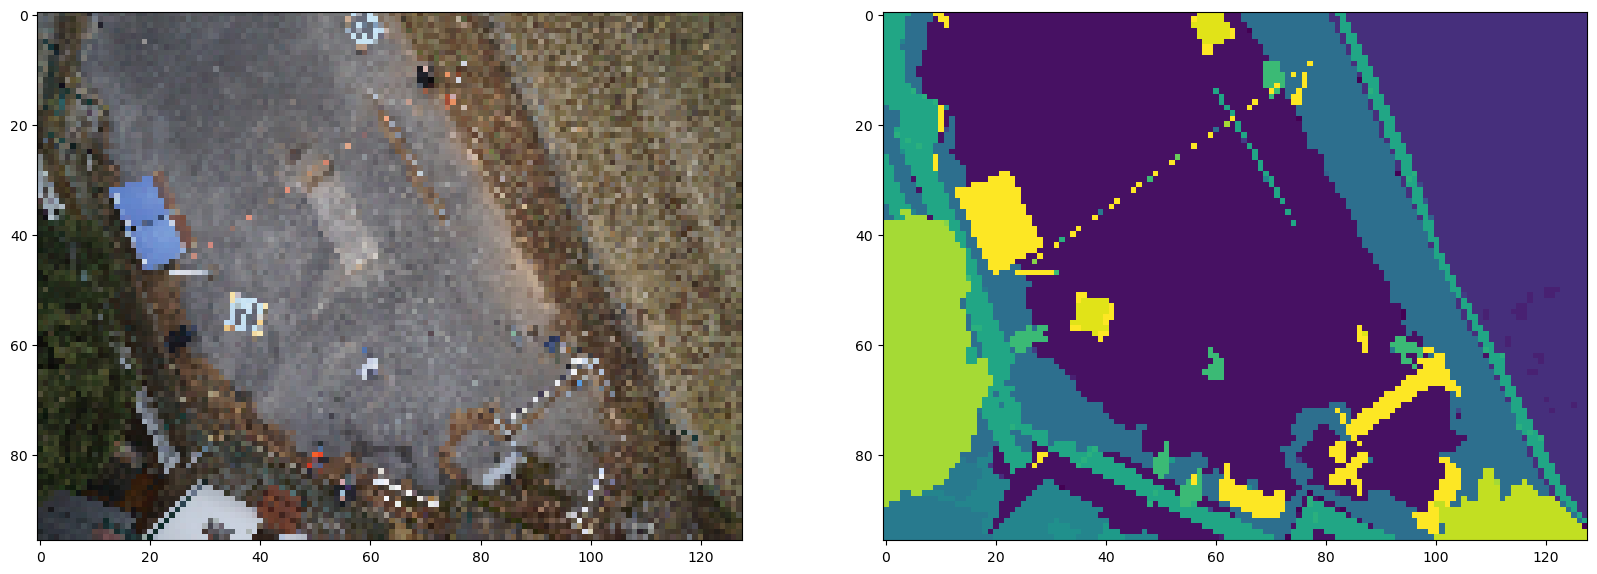

In [182]:
print(X.shape)
print(Y.shape)
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(X[1])
axs[1].imshow(Y[1])

In [183]:
test_image1 = X[-1]
test_label1 = Yc[-1]
test_image2 = X[-2]
test_label2 = Yc[-2]
x_train, x_val, y_train, y_val = train_test_split(X[0:-2], Yc[0:-2], test_size = 0.1)

In [184]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(test_label1.shape)
print(test_label2.shape)

(358, 96, 128, 3)
(358, 96, 128)
(40, 96, 128, 3)
(40, 96, 128)
(96, 128)
(96, 128)


In [185]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    
    conv = Conv2D(n_filters, 
                  kernel_size = 3,     
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
    conv = Conv2D(n_filters, 
                  kernel_size = 3, 
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(conv)
   
    

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
        
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    
    up = Conv2DTranspose(
                 n_filters,  
                 kernel_size = 3,
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,   
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(merge)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(conv)
    
    
    return conv

In [186]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    
    inputs = Input(input_size)
    
    #contracting path
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 4*n_filters)
    cblock4 = conv_block(cblock3[0], 8*n_filters, dropout_prob=0.3) 
    cblock5 = conv_block(cblock4[0],16*n_filters, dropout_prob=0.3, max_pooling=None)     
    
    #expanding path
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  8 * n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7,cblock2[1] , n_filters*2)
    ublock9 = upsampling_block(ublock8,cblock1[1],  n_filters)
    
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    
    conv10 = Conv2D(n_classes, kernel_size=1, padding='same')(conv9)  
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model


img_height = 96*2
img_width = 128*2
num_channels = 3

# unet = unet_model((img_height, img_width, num_channels))


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 96, 128, 32)  896         ['input_2[0][0]']                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 96, 128, 32)  9248        ['conv2d_20[0][0]']              
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 48, 64, 32)  0           ['conv2d_21[0][0]']        

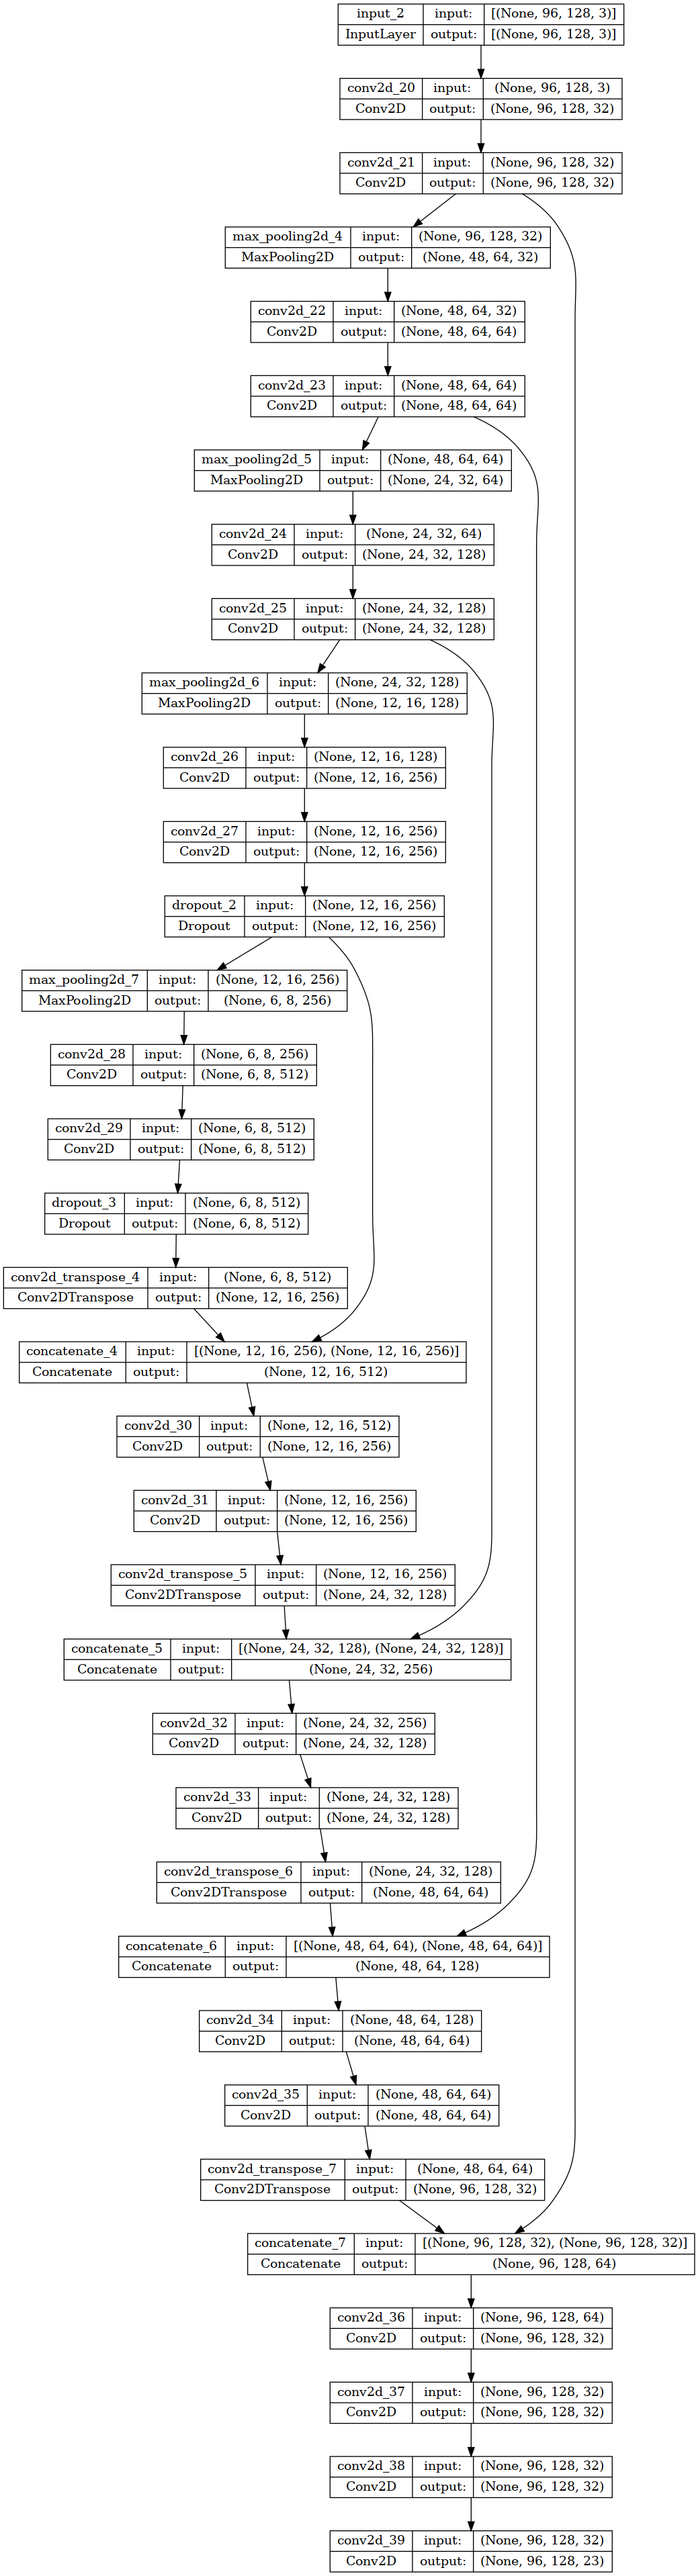

In [187]:
unet.summary()

keras.utils.plot_model(unet, show_shapes=True)

In [188]:
model_checkpoint = ModelCheckpoint('unet_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
model_earlyStopping = EarlyStopping(min_delta= 0.001, patience=50)

In [189]:
def display(display_list):
    plt.figure(figsize=(20, 20))

    try:
    
        title = ['Input Image', 'True Mask', 'Predicted Mask',]

        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(display_list[i])
            plt.axis('off')
        plt.show()
        
    except:
    
        title = ['Input Image 1', 'True Mask 1', 'Predicted Mask 1', 'Input Image 2', 'True Mask 2', 'Predicted Mask 2']

        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(display_list[i])
            plt.axis('off')
        plt.show()

In [190]:
def create_mask(pred_mask):
    pred_mask = tf.where(pred_mask > 0.5,1,0)
#     pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask

In [191]:
import random
train_testing_id = random.randint(0, len(x_train))

In [192]:
def show_predictions(x_train = x_train, y_train = y_train, num=1):
    #try:
    pred_mask = unet.predict(np.expand_dims(x_train[train_testing_id], 0))
    pred_mask = np.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[0]
    display([x_train[train_testing_id], y_train[train_testing_id], pred_mask])

In [193]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
    
    def on_epoch_end(self, epoch, logs=None):
#         clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [194]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [195]:
display_cb = DisplayCallback()

Epoch 1/25
12/12 [==============================] - ETA: 0s - loss: 0.9775 - accuracy: 0.7275
Epoch 1: val_loss improved from inf to 0.81081, saving model to unet_model.hdf5
1/1 [==============================] - 0s 140ms/step


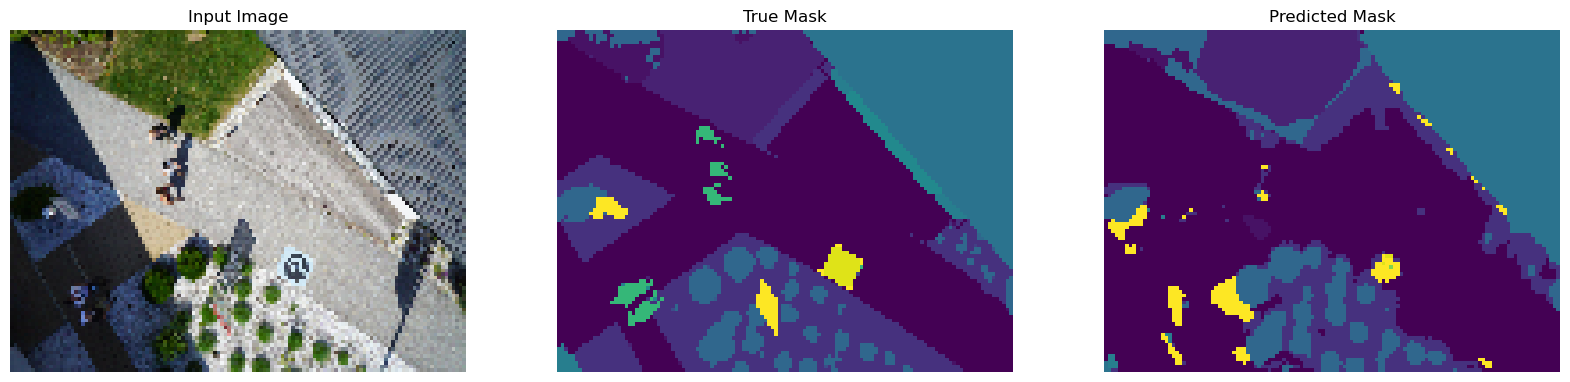


Sample Prediction after epoch 1

12/12 [==============================] - 12s 888ms/step - loss: 0.9775 - accuracy: 0.7275 - val_loss: 0.8108 - val_accuracy: 0.7560
Epoch 2/25
12/12 [==============================] - ETA: 0s - loss: 0.7786 - accuracy: 0.7656
Epoch 2: val_loss improved from 0.81081 to 0.69110, saving model to unet_model.hdf5
1/1 [==============================] - 0s 29ms/step


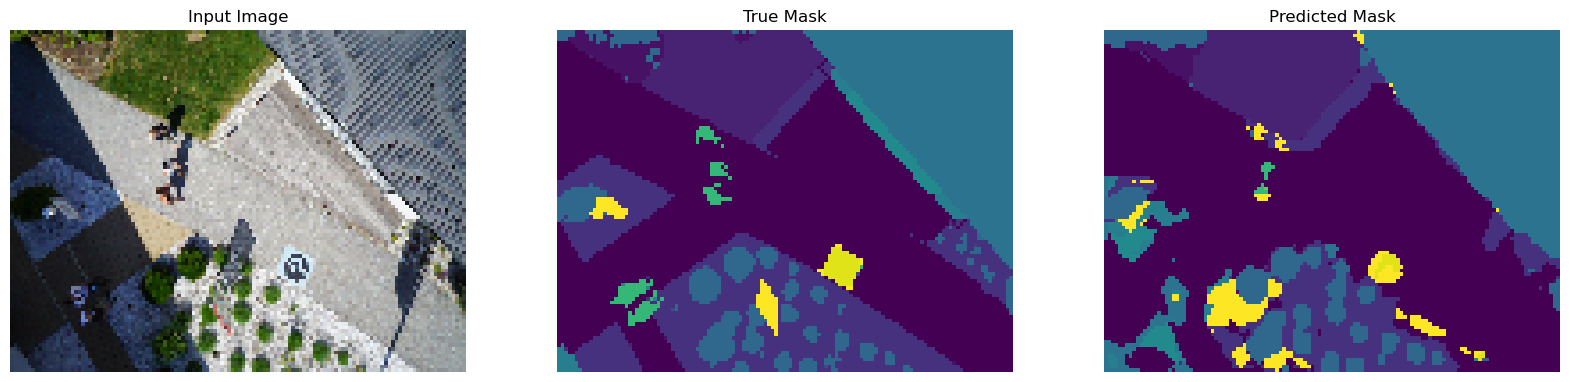


Sample Prediction after epoch 2

12/12 [==============================] - 10s 859ms/step - loss: 0.7786 - accuracy: 0.7656 - val_loss: 0.6911 - val_accuracy: 0.7901
Epoch 3/25
12/12 [==============================] - ETA: 0s - loss: 0.7059 - accuracy: 0.7854
Epoch 3: val_loss improved from 0.69110 to 0.65924, saving model to unet_model.hdf5
1/1 [==============================] - 0s 30ms/step


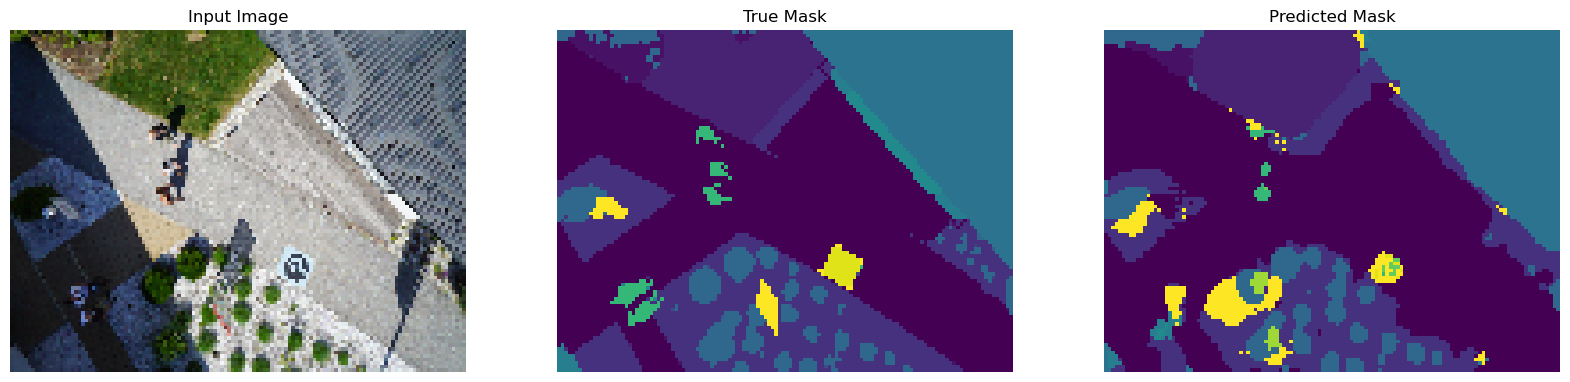


Sample Prediction after epoch 3

12/12 [==============================] - 12s 967ms/step - loss: 0.7059 - accuracy: 0.7854 - val_loss: 0.6592 - val_accuracy: 0.8019
Epoch 4/25
12/12 [==============================] - ETA: 0s - loss: 0.6641 - accuracy: 0.7983
Epoch 4: val_loss improved from 0.65924 to 0.65218, saving model to unet_model.hdf5
1/1 [==============================] - 0s 33ms/step


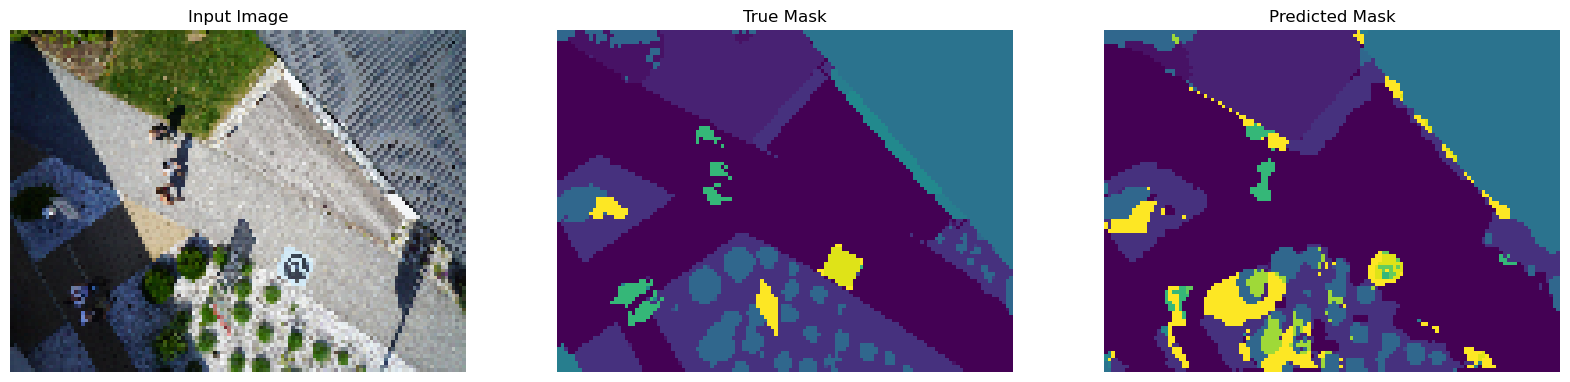


Sample Prediction after epoch 4

12/12 [==============================] - 12s 972ms/step - loss: 0.6641 - accuracy: 0.7983 - val_loss: 0.6522 - val_accuracy: 0.8039
Epoch 5/25
12/12 [==============================] - ETA: 0s - loss: 0.6410 - accuracy: 0.8039
Epoch 5: val_loss improved from 0.65218 to 0.62222, saving model to unet_model.hdf5
1/1 [==============================] - 0s 30ms/step


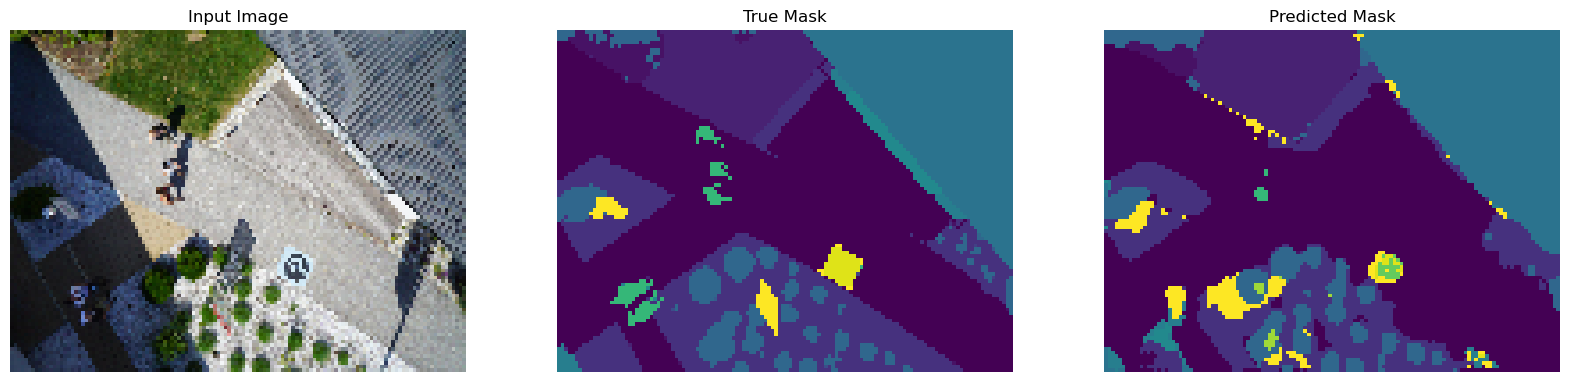


Sample Prediction after epoch 5

12/12 [==============================] - 12s 969ms/step - loss: 0.6410 - accuracy: 0.8039 - val_loss: 0.6222 - val_accuracy: 0.8103
Epoch 6/25
12/12 [==============================] - ETA: 0s - loss: 0.6171 - accuracy: 0.8106
Epoch 6: val_loss did not improve from 0.62222
1/1 [==============================] - 0s 29ms/step


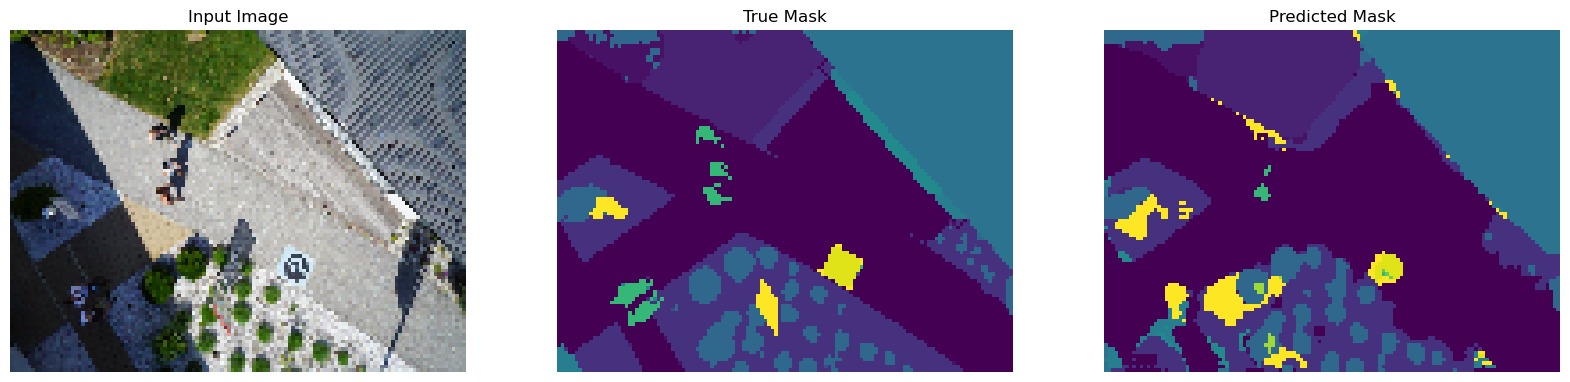


Sample Prediction after epoch 6

12/12 [==============================] - 11s 953ms/step - loss: 0.6171 - accuracy: 0.8106 - val_loss: 0.6298 - val_accuracy: 0.8101
Epoch 7/25
12/12 [==============================] - ETA: 0s - loss: 0.5994 - accuracy: 0.8163
Epoch 7: val_loss did not improve from 0.62222
1/1 [==============================] - 0s 31ms/step


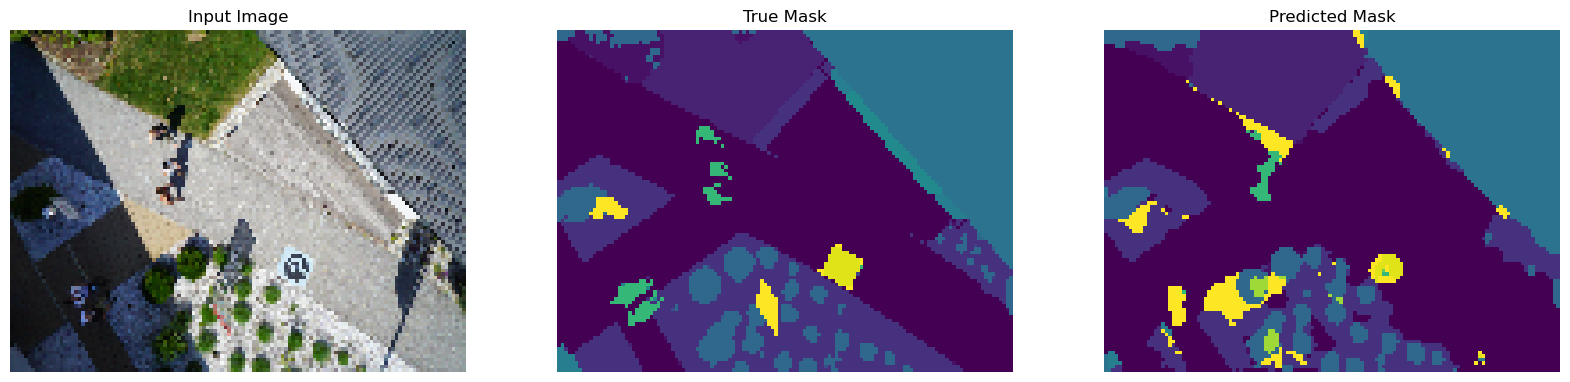


Sample Prediction after epoch 7

12/12 [==============================] - 11s 951ms/step - loss: 0.5994 - accuracy: 0.8163 - val_loss: 0.6223 - val_accuracy: 0.8108
Epoch 8/25
12/12 [==============================] - ETA: 0s - loss: 0.5918 - accuracy: 0.8178
Epoch 8: val_loss improved from 0.62222 to 0.61751, saving model to unet_model.hdf5
1/1 [==============================] - 0s 30ms/step


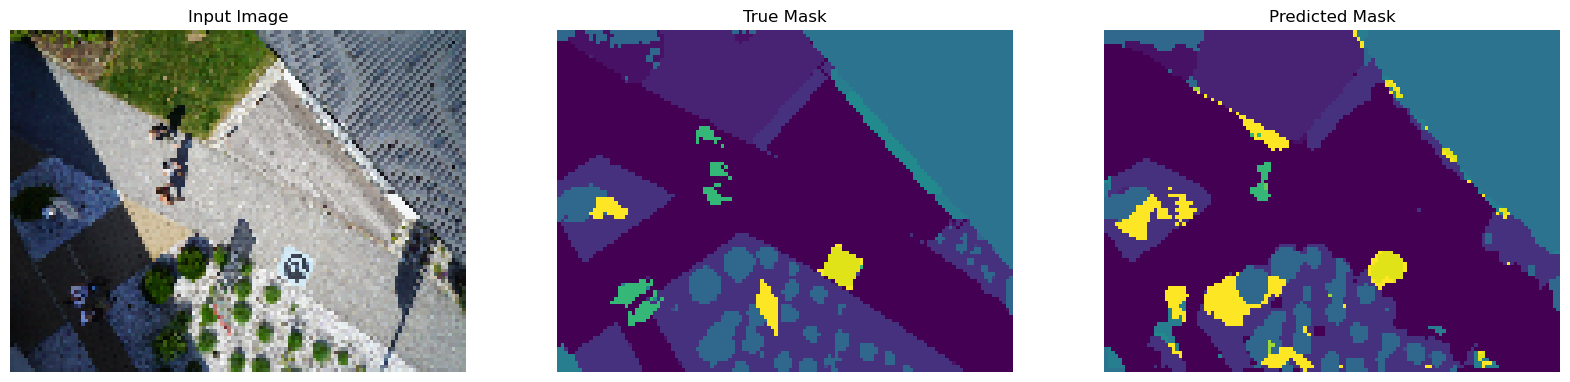


Sample Prediction after epoch 8

12/12 [==============================] - 12s 961ms/step - loss: 0.5918 - accuracy: 0.8178 - val_loss: 0.6175 - val_accuracy: 0.8130
Epoch 9/25
12/12 [==============================] - ETA: 0s - loss: 0.5778 - accuracy: 0.8224
Epoch 9: val_loss did not improve from 0.61751
1/1 [==============================] - 0s 32ms/step


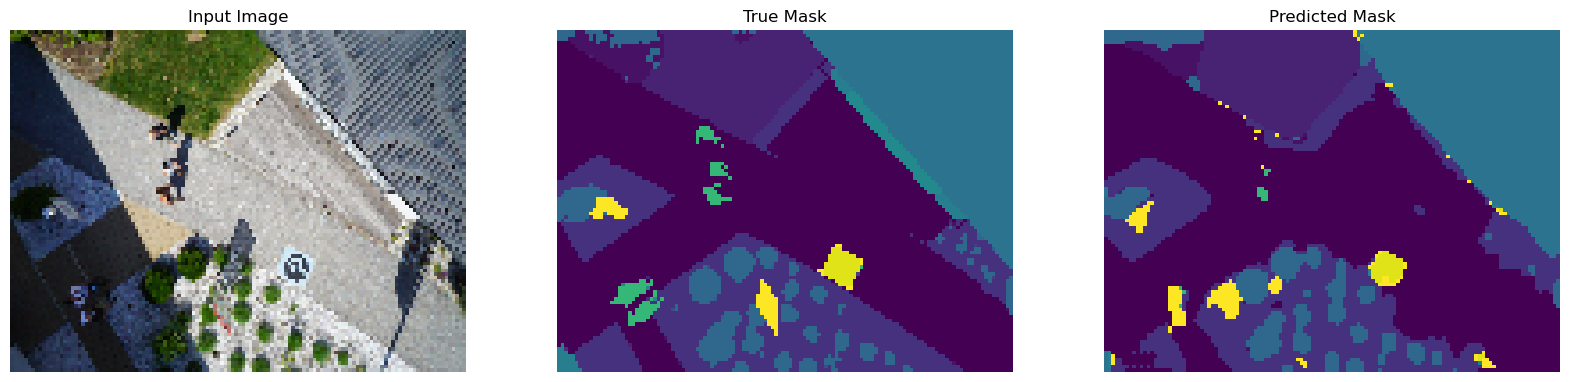


Sample Prediction after epoch 9

12/12 [==============================] - 11s 954ms/step - loss: 0.5778 - accuracy: 0.8224 - val_loss: 0.6180 - val_accuracy: 0.8126
Epoch 10/25
12/12 [==============================] - ETA: 0s - loss: 0.5598 - accuracy: 0.8271
Epoch 10: val_loss improved from 0.61751 to 0.60879, saving model to unet_model.hdf5
1/1 [==============================] - 0s 30ms/step


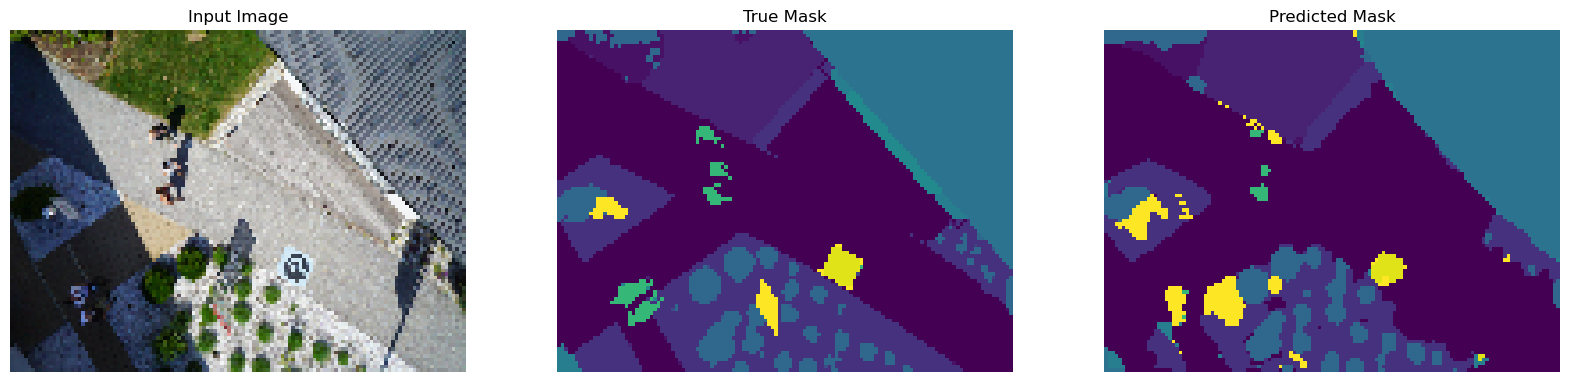


Sample Prediction after epoch 10

12/12 [==============================] - 12s 993ms/step - loss: 0.5598 - accuracy: 0.8271 - val_loss: 0.6088 - val_accuracy: 0.8154
Epoch 11/25
12/12 [==============================] - ETA: 0s - loss: 0.5488 - accuracy: 0.8309
Epoch 11: val_loss did not improve from 0.60879
1/1 [==============================] - 0s 32ms/step


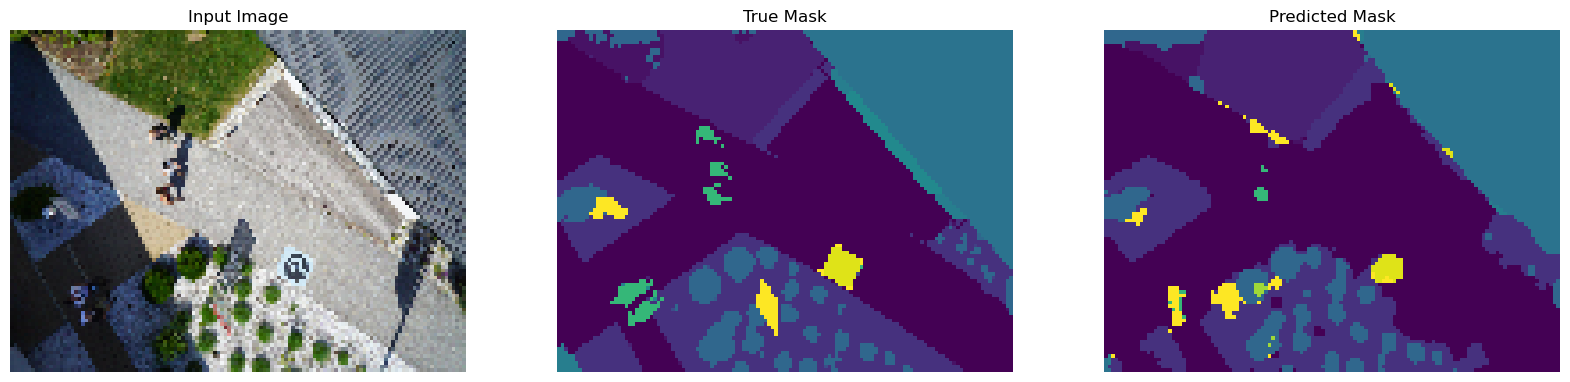


Sample Prediction after epoch 11

12/12 [==============================] - 11s 953ms/step - loss: 0.5488 - accuracy: 0.8309 - val_loss: 0.6152 - val_accuracy: 0.8159
Epoch 12/25
12/12 [==============================] - ETA: 0s - loss: 0.5362 - accuracy: 0.8342
Epoch 12: val_loss did not improve from 0.60879
1/1 [==============================] - 0s 33ms/step


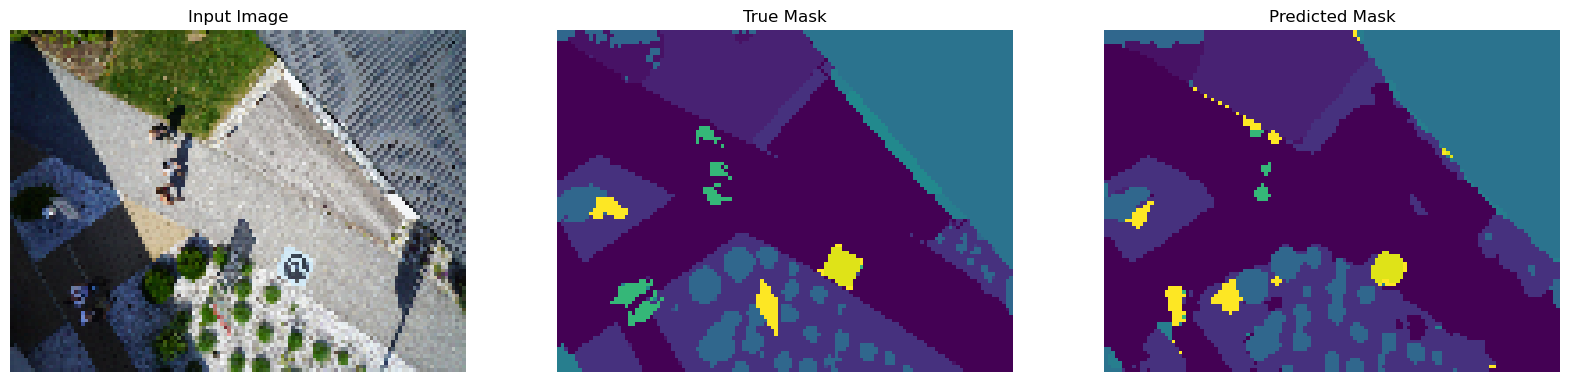


Sample Prediction after epoch 12

12/12 [==============================] - 11s 950ms/step - loss: 0.5362 - accuracy: 0.8342 - val_loss: 0.6202 - val_accuracy: 0.8120
Epoch 13/25
12/12 [==============================] - ETA: 0s - loss: 0.5323 - accuracy: 0.8364
Epoch 13: val_loss did not improve from 0.60879
1/1 [==============================] - 0s 34ms/step


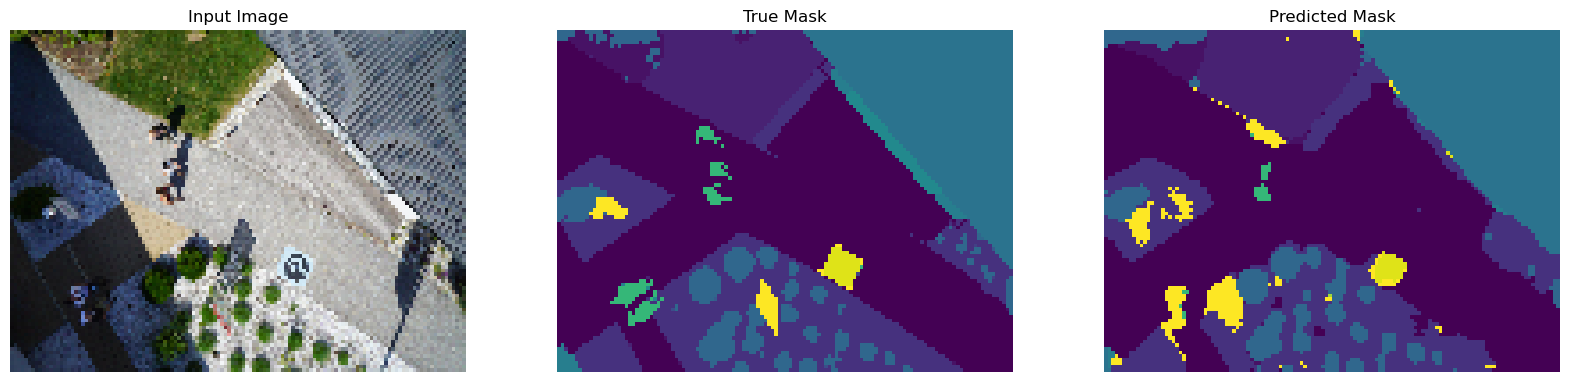


Sample Prediction after epoch 13

12/12 [==============================] - 11s 951ms/step - loss: 0.5323 - accuracy: 0.8364 - val_loss: 0.6432 - val_accuracy: 0.8048
Epoch 14/25
12/12 [==============================] - ETA: 0s - loss: 0.5246 - accuracy: 0.8377
Epoch 14: val_loss improved from 0.60879 to 0.59906, saving model to unet_model.hdf5
1/1 [==============================] - 0s 34ms/step


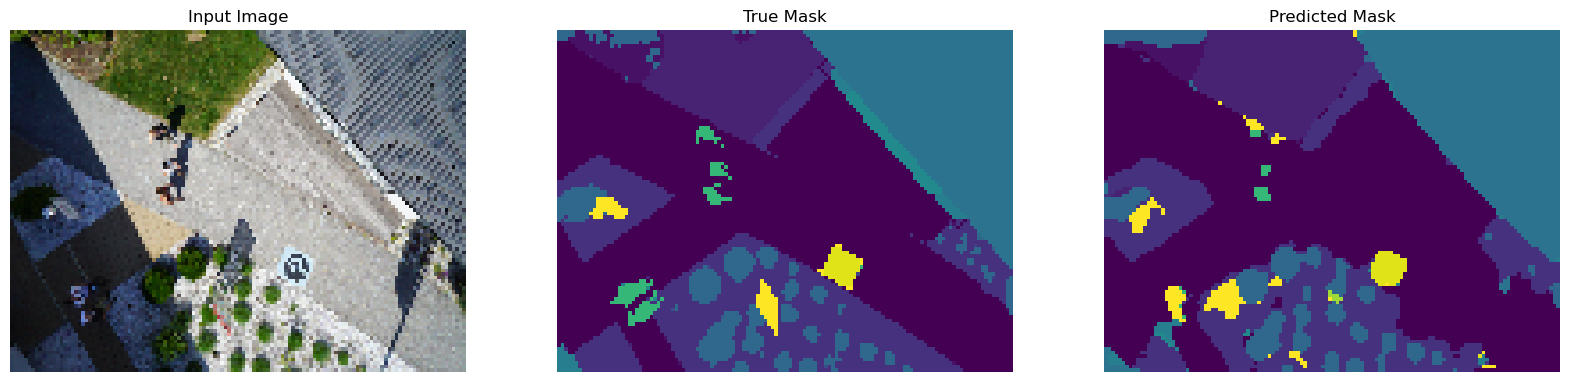


Sample Prediction after epoch 14

12/12 [==============================] - 12s 963ms/step - loss: 0.5246 - accuracy: 0.8377 - val_loss: 0.5991 - val_accuracy: 0.8174
Epoch 15/25
12/12 [==============================] - ETA: 0s - loss: 0.5137 - accuracy: 0.8409
Epoch 15: val_loss did not improve from 0.59906
1/1 [==============================] - 0s 34ms/step


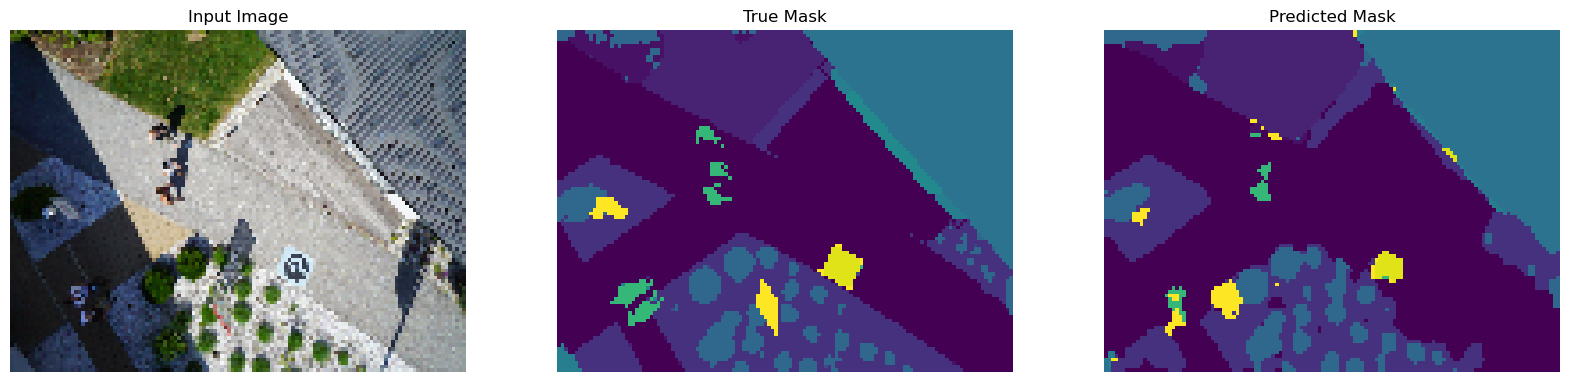


Sample Prediction after epoch 15

12/12 [==============================] - 11s 955ms/step - loss: 0.5137 - accuracy: 0.8409 - val_loss: 0.6313 - val_accuracy: 0.8121
Epoch 16/25
12/12 [==============================] - ETA: 0s - loss: 0.4990 - accuracy: 0.8457
Epoch 16: val_loss did not improve from 0.59906
1/1 [==============================] - 0s 31ms/step


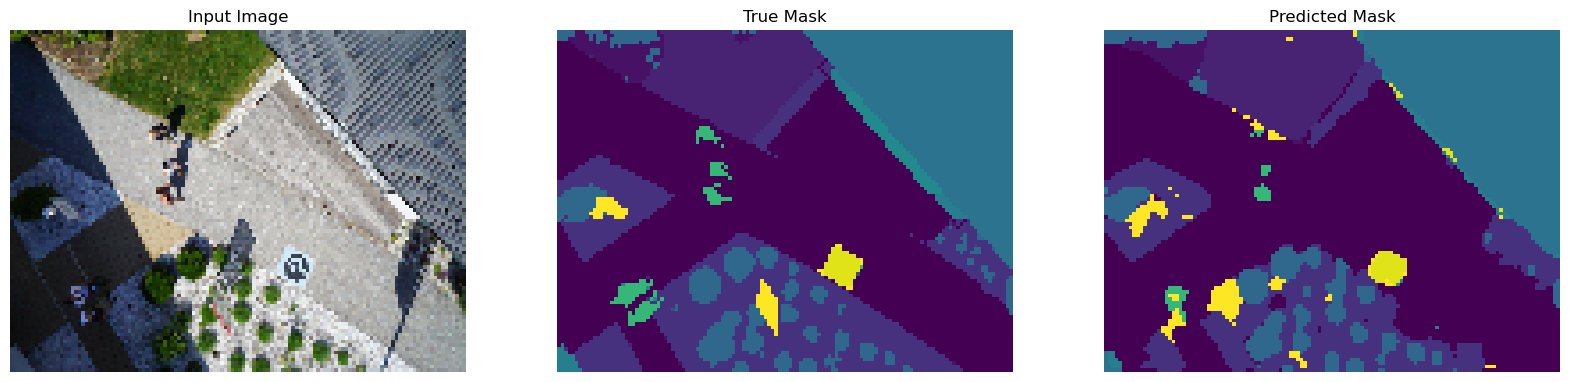


Sample Prediction after epoch 16

12/12 [==============================] - 11s 948ms/step - loss: 0.4990 - accuracy: 0.8457 - val_loss: 0.6128 - val_accuracy: 0.8165
Epoch 17/25
12/12 [==============================] - ETA: 0s - loss: 0.4875 - accuracy: 0.8493
Epoch 17: val_loss did not improve from 0.59906
1/1 [==============================] - 0s 30ms/step


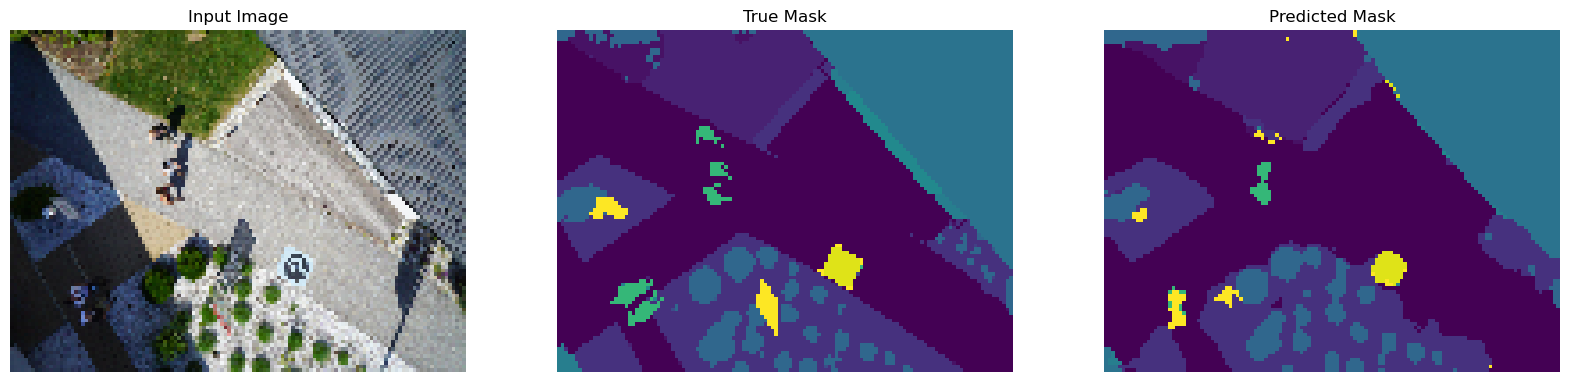


Sample Prediction after epoch 17

12/12 [==============================] - 11s 951ms/step - loss: 0.4875 - accuracy: 0.8493 - val_loss: 0.6139 - val_accuracy: 0.8183
Epoch 18/25
12/12 [==============================] - ETA: 0s - loss: 0.4833 - accuracy: 0.8499
Epoch 18: val_loss did not improve from 0.59906
1/1 [==============================] - 0s 32ms/step


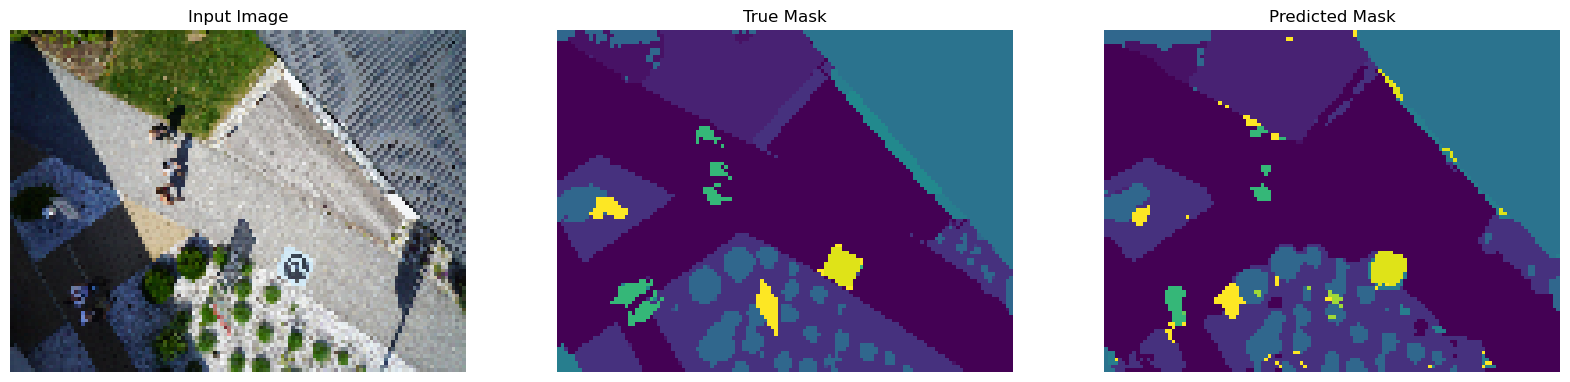


Sample Prediction after epoch 18

12/12 [==============================] - 11s 955ms/step - loss: 0.4833 - accuracy: 0.8499 - val_loss: 0.6189 - val_accuracy: 0.8135
Epoch 19/25
12/12 [==============================] - ETA: 0s - loss: 0.4754 - accuracy: 0.8529
Epoch 19: val_loss did not improve from 0.59906
1/1 [==============================] - 0s 30ms/step


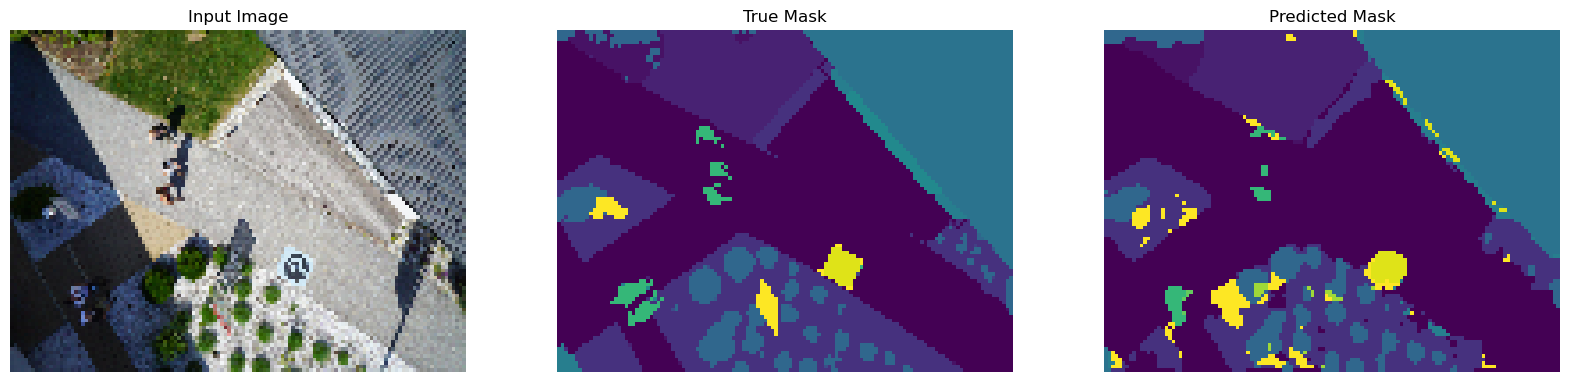


Sample Prediction after epoch 19

12/12 [==============================] - 11s 956ms/step - loss: 0.4754 - accuracy: 0.8529 - val_loss: 0.6763 - val_accuracy: 0.8047
Epoch 20/25
12/12 [==============================] - ETA: 0s - loss: 0.4767 - accuracy: 0.8519
Epoch 20: val_loss did not improve from 0.59906
1/1 [==============================] - 0s 30ms/step


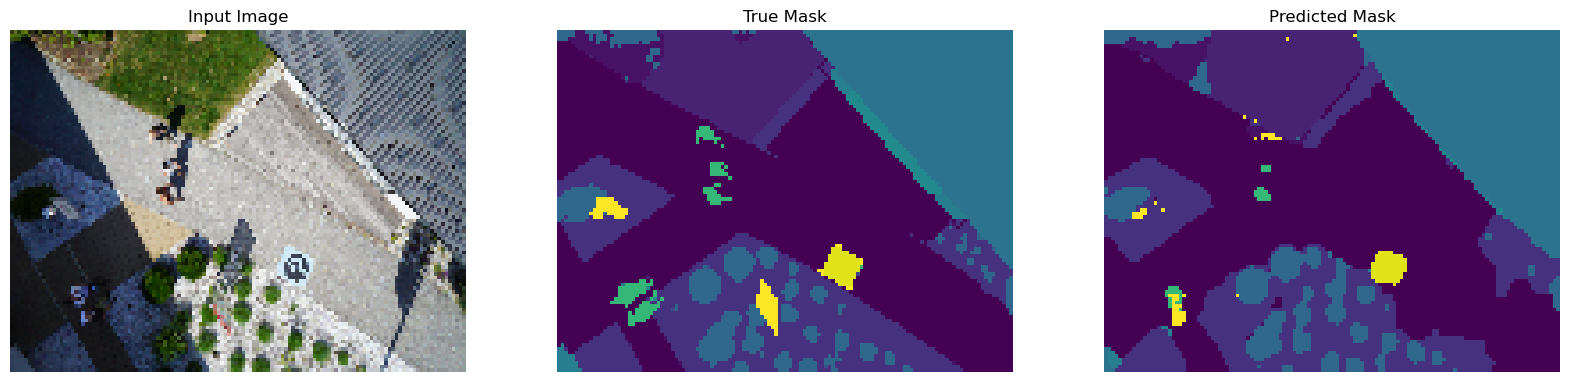


Sample Prediction after epoch 20

12/12 [==============================] - 11s 947ms/step - loss: 0.4767 - accuracy: 0.8519 - val_loss: 0.6371 - val_accuracy: 0.8129
Epoch 21/25
12/12 [==============================] - ETA: 0s - loss: 0.4746 - accuracy: 0.8533
Epoch 21: val_loss did not improve from 0.59906
1/1 [==============================] - 0s 30ms/step


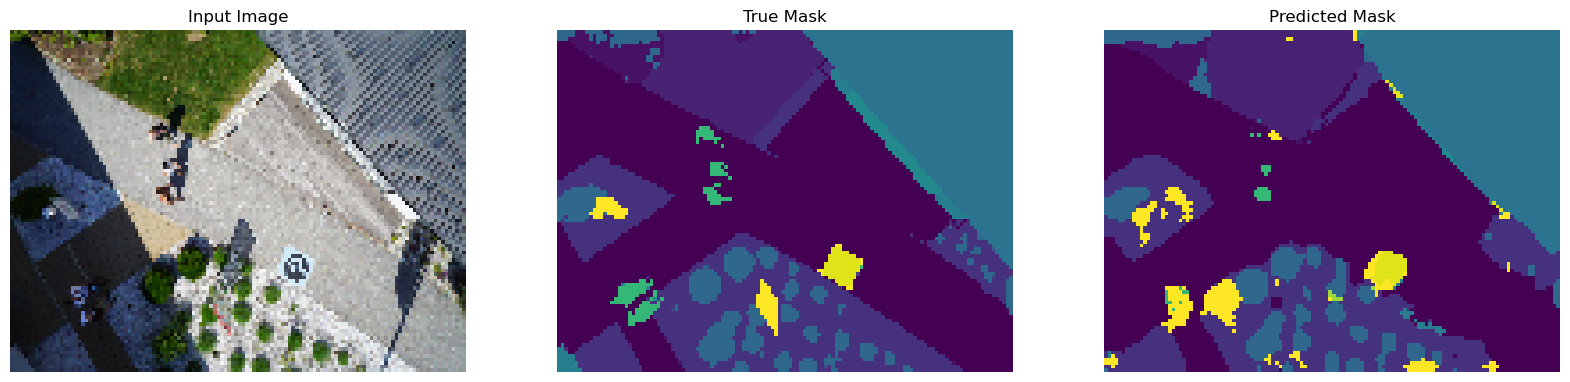


Sample Prediction after epoch 21

12/12 [==============================] - 11s 950ms/step - loss: 0.4746 - accuracy: 0.8533 - val_loss: 0.6245 - val_accuracy: 0.8168
Epoch 22/25
12/12 [==============================] - ETA: 0s - loss: 0.4537 - accuracy: 0.8603
Epoch 22: val_loss did not improve from 0.59906
1/1 [==============================] - 0s 30ms/step


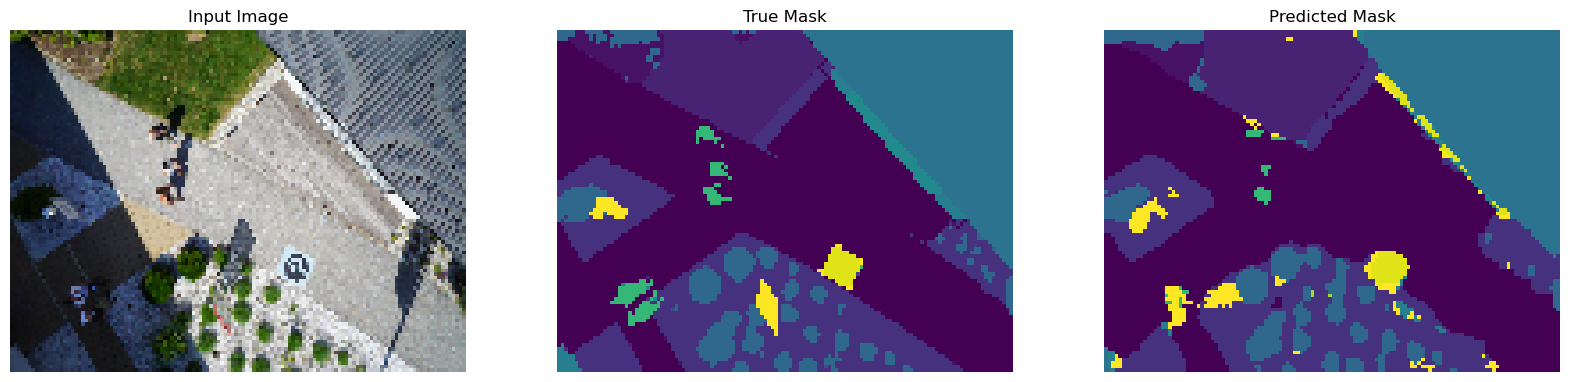


Sample Prediction after epoch 22

12/12 [==============================] - 11s 950ms/step - loss: 0.4537 - accuracy: 0.8603 - val_loss: 0.6573 - val_accuracy: 0.8087
Epoch 23/25
12/12 [==============================] - ETA: 0s - loss: 0.4450 - accuracy: 0.8624
Epoch 23: val_loss did not improve from 0.59906
1/1 [==============================] - 0s 28ms/step


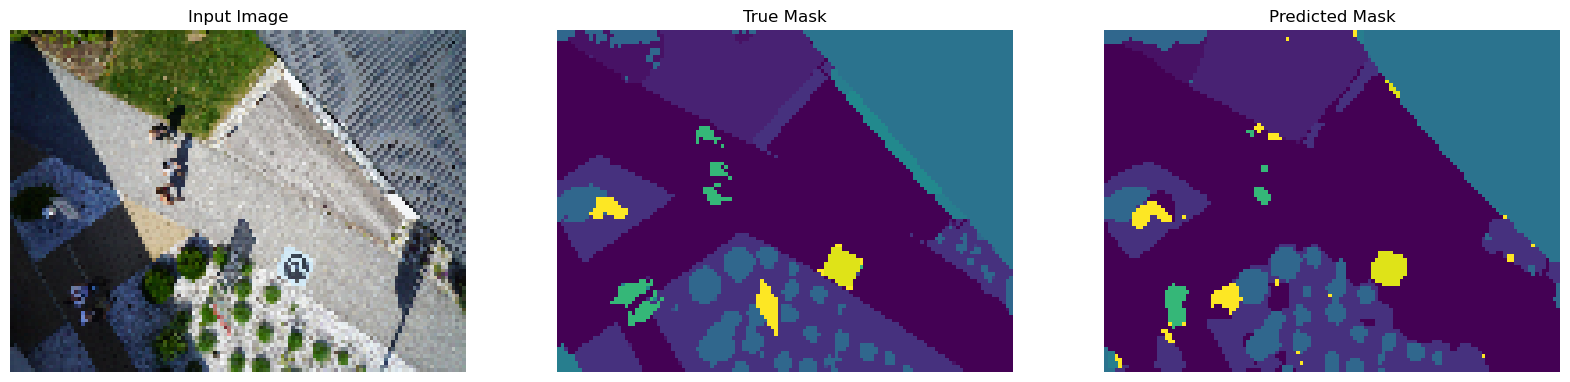


Sample Prediction after epoch 23

12/12 [==============================] - 11s 957ms/step - loss: 0.4450 - accuracy: 0.8624 - val_loss: 0.7221 - val_accuracy: 0.8002
Epoch 24/25
12/12 [==============================] - ETA: 0s - loss: 0.7082 - accuracy: 0.7899
Epoch 24: val_loss did not improve from 0.59906
1/1 [==============================] - 0s 29ms/step


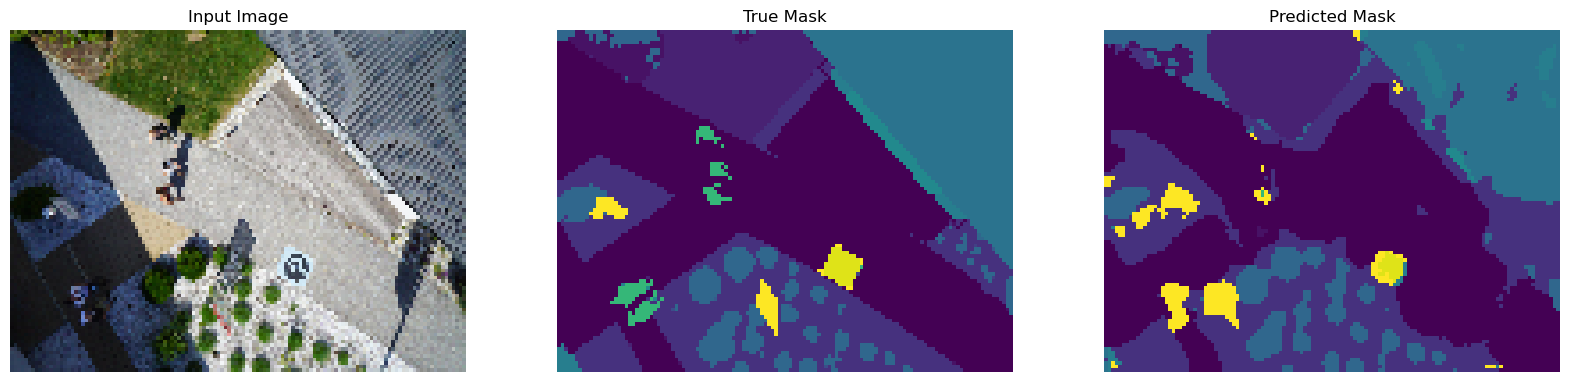


Sample Prediction after epoch 24

12/12 [==============================] - 11s 950ms/step - loss: 0.7082 - accuracy: 0.7899 - val_loss: 0.8196 - val_accuracy: 0.7575
Epoch 25/25
12/12 [==============================] - ETA: 0s - loss: 0.6695 - accuracy: 0.7946
Epoch 25: val_loss did not improve from 0.59906
1/1 [==============================] - 0s 35ms/step


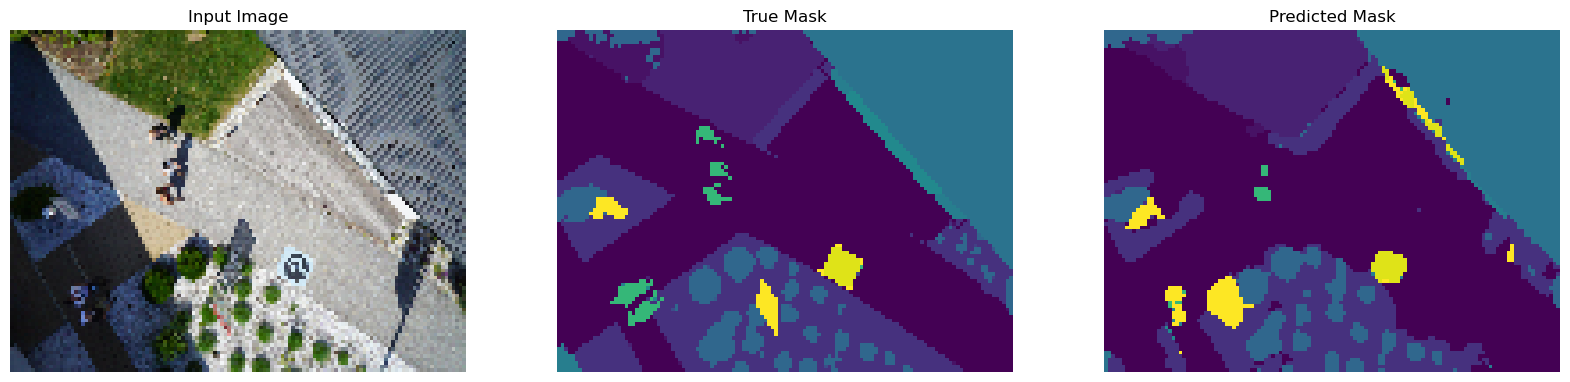


Sample Prediction after epoch 25

12/12 [==============================] - 11s 955ms/step - loss: 0.6695 - accuracy: 0.7946 - val_loss: 0.7814 - val_accuracy: 0.7746


In [196]:
history = unet.fit(x=x_train, y=y_train,
              validation_data=(x_val, y_val),
              batch_size=32, epochs=20,
              callbacks=[model_checkpoint, model_earlyStopping, display_cb])

In [197]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

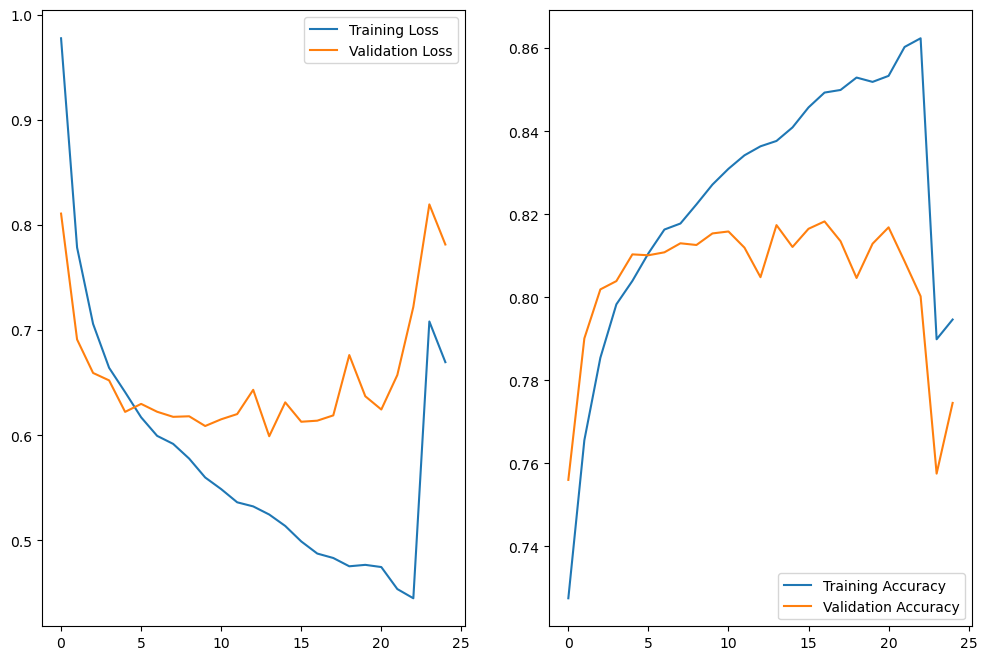

1/1 [==============================] - 0s 28ms/step
42
(358, 96, 128, 23)
(96, 128, 23)
1
0
0.29172681725543476
0.45455723660442243
82449


In [198]:
# Plot loss and accuracy curves
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Predict on train, val and test
preds_train = unet.predict(x_train, verbose=1)
preds_val = unet.predict(x_val, verbose=1)
preds_test1 = unet.predict(np.expand_dims(test_image1, 0), verbose=1)
preds_test2 = unet.predict(np.expand_dims(test_image2, 0), verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test1_t = (preds_test1 > 0.5).astype(np.uint8)
preds_test2_t = (preds_test2 > 0.5).astype(np.uint8)

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
print(ix)
print(preds_train_t.shape)
print(preds_train_t[ix].shape)
print(preds_train_t[ix].max())
print(preds_train_t[ix].min())
print(preds_train_t[ix].mean())
print(preds_train_t[ix].std())
print(preds_train_t[ix].sum())



In [199]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate

# imports
import time
from time import process_time
import numpy as np
import numpy
import scipy.io
import cv2
from tensorboard import notebook
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, recall_score, f1_score,confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.transform import resize
from skimage.color import convert_colorspace
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout

In [200]:
def train_and_eval(model, train, train_y, test, test_y):

    # compile the network
    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    
    # fit the model
    # make the batch size smaller
    # increase the epochs number of iterations of the dataset
    # add decay rate for epoch
    history = model.fit(train, train_y,
                        batch_size=16,
                        epochs=1,
                        validation_data=(test, test_y),
                        verbose=False)
    

    # plot training and validation loss and accuracy
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history['loss'], label="Training Loss")
    ax.plot(history.history['val_loss'], label="Validation Loss")
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history['accuracy'], label="Training Accuracy")
    ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
    ax.legend()

    # plot confusion matrices and F1 scores
    fig = plt.figure(figsize=[20, 8])    

    ax = fig.add_subplot(1, 2, 1)    
    pred = model.predict(train, verbose=False);
    indexes = tf.argmax(pred, axis=1)
    gt_idx = tf.argmax(train_y, axis=1)

    confusion_mtx = tf.math.confusion_matrix(gt_idx, indexes) 
    sns.heatmap(confusion_mtx, xticklabels=range(10), yticklabels=range(10), 
            annot=True, fmt='g', ax=ax)
    ax.set_title('Training, F1 Score: %f' % f1_score(gt_idx, indexes, average='weighted'))

    ax = fig.add_subplot(1, 2, 2)    
    pred = model.predict(test, verbose=False);
    indexes = tf.argmax(pred, axis=1)
    gt_idx = tf.argmax(test_y, axis=1)

    confusion_mtx = tf.math.confusion_matrix(gt_idx, indexes) 
    sns.heatmap(confusion_mtx, xticklabels=range(10), yticklabels=range(10), 
            annot=True, fmt='g', ax=ax)
    ax.set_title('Testing, F1 Score: %f' % f1_score(gt_idx, indexes, average='weighted'))


train_and_eval(unet, x_train, y_train, test_image1, test_label1 )


# history = unet.fit(x=x_train, y=y_train,
#               validation_data=(x_val, y_val),
#               batch_size=16, epochs=10,
#               callbacks=[model_checkpoint, model_earlyStopping, display_cb])

# def show_predictions(x_train = x_train, y_train = y_train, num=1):
#     #try:
#     pred_mask = unet.predict(np.expand_dims(x_train[train_testing_id], 0))
#     pred_mask = np.argmax(pred_mask, axis=-1)
#     pred_mask = pred_mask[0]
#     display([x_train[train_testing_id], y_train[train_testing_id], pred_mask])
     

ValueError: in user code:

    File "/home/don/anaconda3/envs/cab420/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/don/anaconda3/envs/cab420/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/don/anaconda3/envs/cab420/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/don/anaconda3/envs/cab420/lib/python3.10/site-packages/keras/engine/training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/don/anaconda3/envs/cab420/lib/python3.10/site-packages/keras/engine/training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "/home/don/anaconda3/envs/cab420/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/don/anaconda3/envs/cab420/lib/python3.10/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/don/anaconda3/envs/cab420/lib/python3.10/site-packages/keras/losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/don/anaconda3/envs/cab420/lib/python3.10/site-packages/keras/losses.py", line 2004, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/home/don/anaconda3/envs/cab420/lib/python3.10/site-packages/keras/backend.py", line 5532, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 96, 128) and (None, 96, 128, 23) are incompatible


Text(0.5, 1.0, 'Training and Validation Loss')

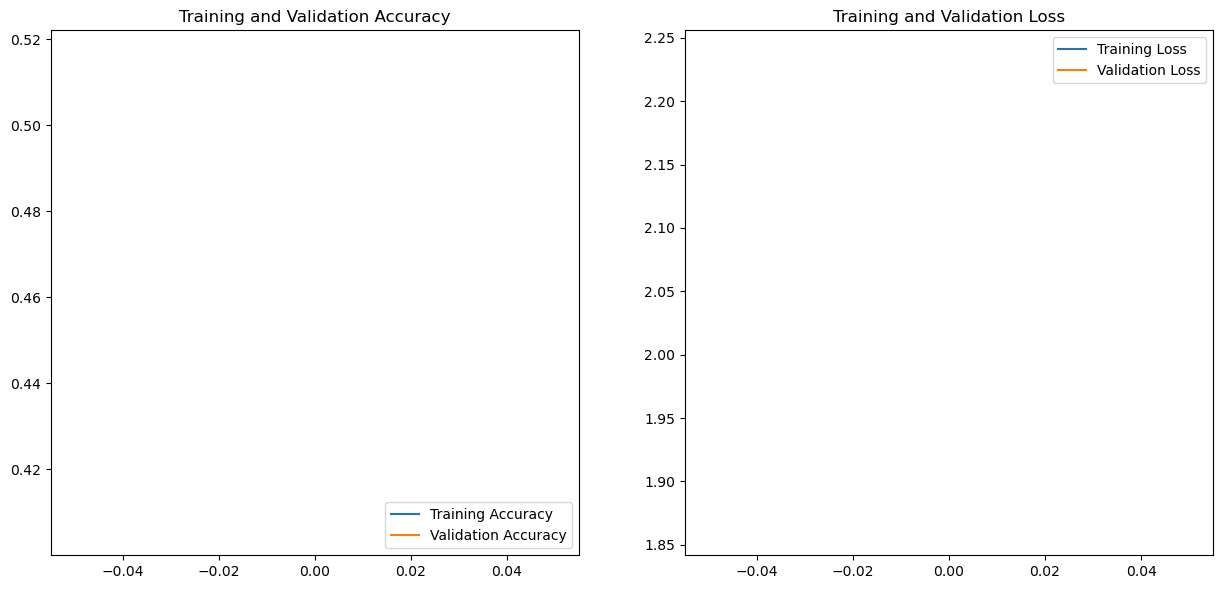

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [ ]:
m1 = test_image1
pred = unet.predict(np.expand_dims(m1, 0))
pred_mask = np.argmax(pred, axis=-1)
pred_mask = pred_mask[0]
pred_mask_test = pred_mask
print(pred_mask.shape)

1/1 [==============================] - 0s 32ms/step
(96, 128)


In [ ]:
m2 = test_image2
pred2 = unet.predict(np.expand_dims(m2, 0))

pred_mask2 = np.argmax(pred2, axis=-1)
pred_mask2 = pred_mask2[0]
print(pred_mask2)

1/1 [==============================] - 0s 38ms/step
[[1 1 1 ... 1 3 1]
 [1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 3]
 ...
 [1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 4]]


Text(0.5, 1.0, 'Prediction')

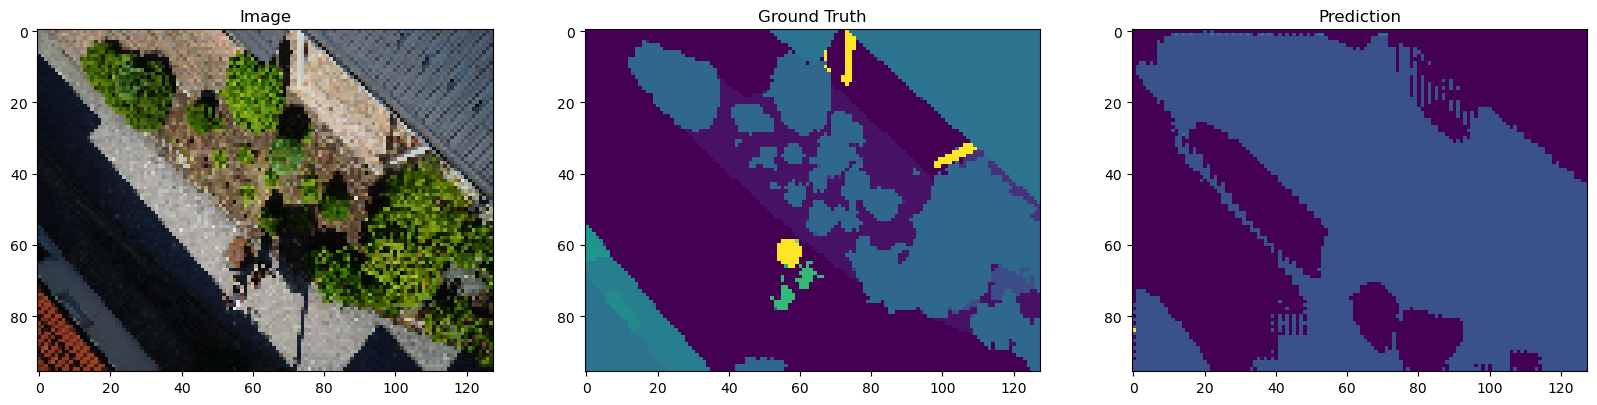

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(m1)
axs[0].set_title('Image')
axs[1].imshow(test_label1)
axs[1].set_title('Ground Truth')
axs[2].imshow(pred_mask)
axs[2].set_title('Prediction')

In [ ]:
labels = pd.read_csv('/home/don/Git/aerial-semantic-segmentation/dataset_here/class_dict_seg.csv')


labels


name    r    g    b
0     unlabeled    0    0    0
1    paved-area  128   64  128
2          dirt  130   76    0
3         grass    0  102    0
4        gravel  112  103   87
5         water   28   42  168
6         rocks   48   41   30
7          pool    0   50   89
8    vegetation  107  142   35
9          roof   70   70   70
10         wall  102  102  156
11       window  254  228   12
12         door  254  148   12
13        fence  190  153  153
14   fence-pole  153  153  153
15       person  255   22   96
16          dog  102   51    0
17          car    9  143  150
18      bicycle  119   11   32
19         tree   51   51    0
20    bald-tree  190  250  190
21    ar-marker  112  150  146
22     obstacle    2  135  115
23  conflicting  255    0    0

In [ ]:
labels = labels['name'].values
print(labels)

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(test_label1, pred_mask)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

# Plot confusion matrix
cm = confusion_matrix(test_label2, pred_mask2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()



ValueError: Classification metrics can't handle a mix of multiclass-multioutput and unknown targets

Text(0.5, 1.0, 'Prediction')

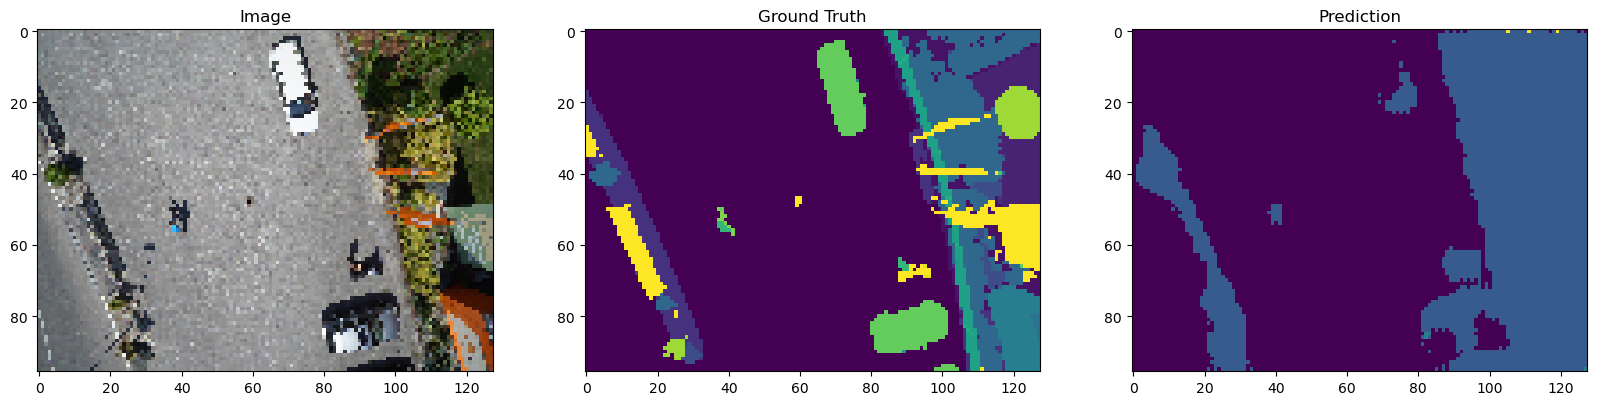

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(m2)
axs[0].set_title('Image')
axs[1].imshow(test_label2)
axs[1].set_title('Ground Truth')
axs[2].imshow(pred_mask2)
axs[2].set_title('Prediction')

In [ ]:
new_model = tf.keras.models.load_model('unet_model.hdf5')

# Show the model architecture
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 96, 128, 32)  896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 96, 128, 32)  9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 48, 64, 32)   0           ['conv2d_1[0][0]']           

In [ ]:
loss, acc = new_model.evaluate(x_val, y_val, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

2/2 - 1s - loss: 1.8605 - accuracy: 0.5166 - 633ms/epoch - 316ms/step
Restored model, accuracy: 51.66%


In [ ]:
new_pred = new_model.predict(np.expand_dims(m1, 0))
new_pred = np.argmax(new_pred, axis=-1)
new_pred = new_pred[0]

1/1 [==============================] - 0s 144ms/step


Text(0.5, 1.0, 'Prediction')

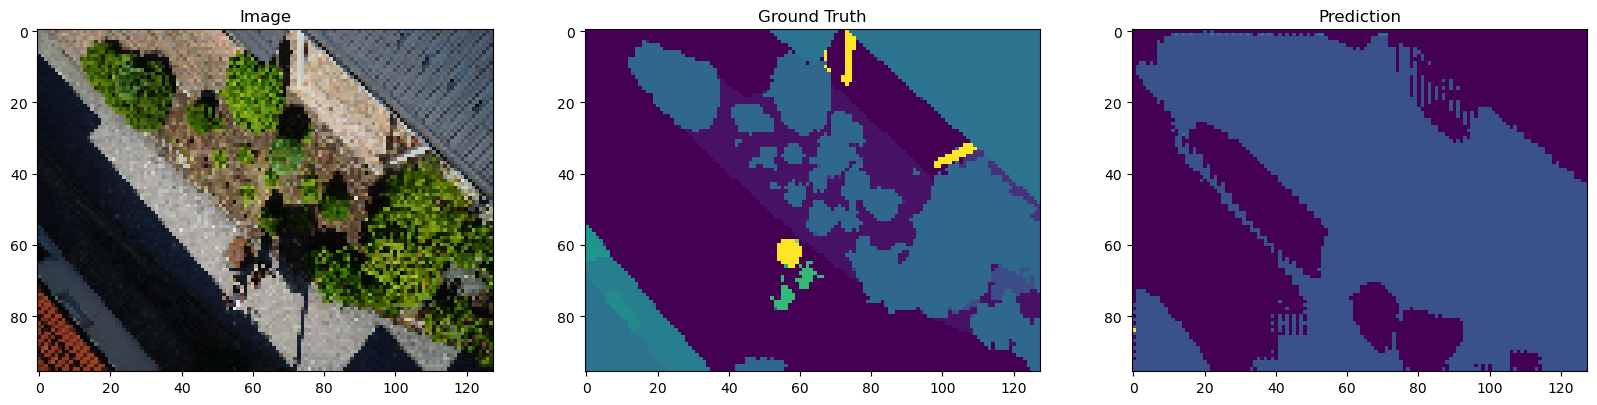

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(m1)
axs[0].set_title('Image')
axs[1].imshow(test_label1)
axs[1].set_title('Ground Truth')
axs[2].imshow(new_pred)
axs[2].set_title('Prediction')

In [ ]:
print(type(new_pred))

<class 'numpy.ndarray'>


In [ ]:
print(pred_mask.max())

9


In [ ]:
from matplotlib import cm

pred_mask = np.asarray(pred_mask, dtype='int32')
pred_mask = pred_mask / 255

pred_mask = cm.viridis(pred_mask)*255

In [ ]:
pred_mask = np.asarray(pred_mask, dtype='uint8')

Text(0.5, 1.0, 'Prediction')

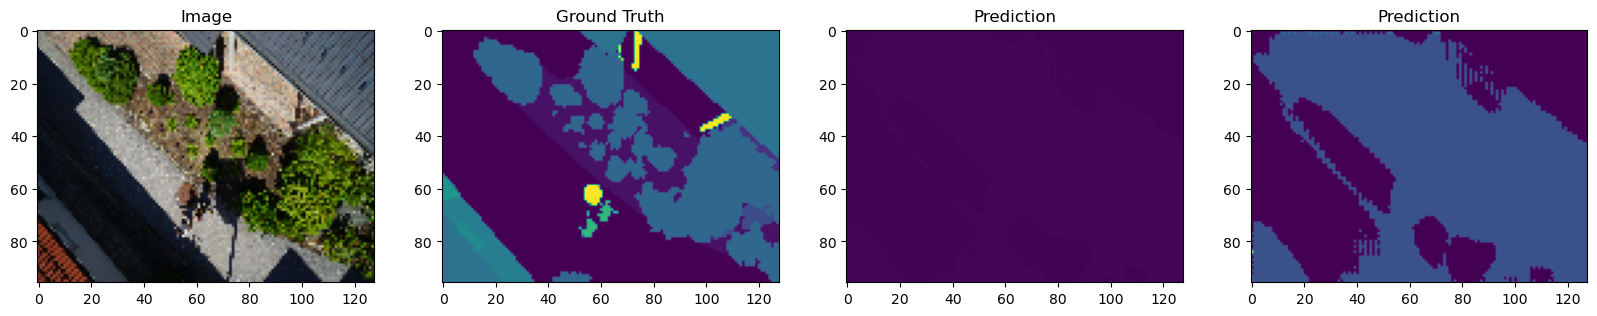

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 10))
axs[0].imshow(m1)
axs[0].set_title('Image')
axs[1].imshow(test_label1)
axs[1].set_title('Ground Truth')
axs[2].imshow(pred_mask)
axs[2].set_title('Prediction')
axs[3].imshow(new_pred)
axs[3].set_title('Prediction')

In [ ]:
pred_mask_test = np.asarray(pred_mask_test)
pred_mask_test = (pred_mask_test - np.min(pred_mask_test)) / (np.max(pred_mask_test) - np.min(pred_mask_test))
pred_mask_test = cm.viridis(pred_mask_test)*255
pred_mask_test = np.asarray(pred_mask_test, dtype='uint8')

Text(0.5, 1.0, 'Prediction')

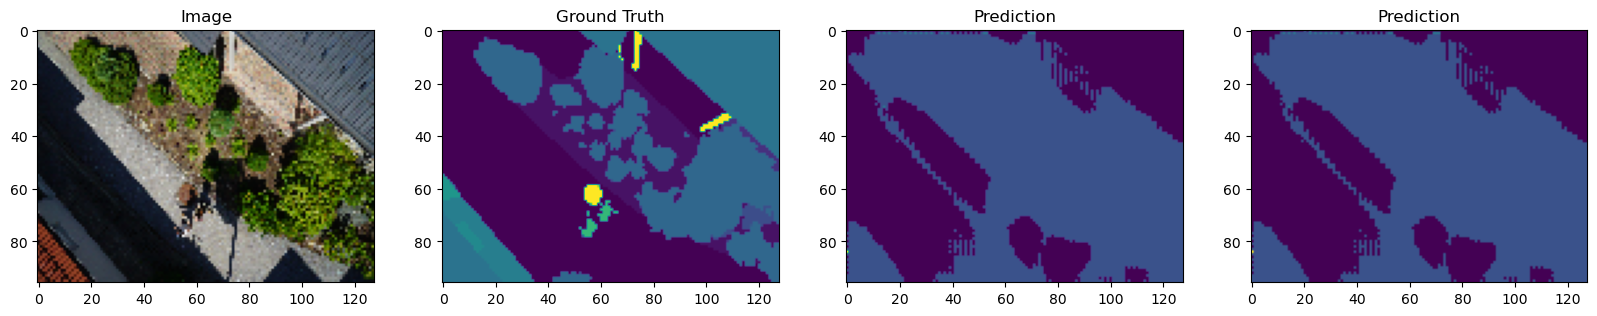

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 10))
axs[0].imshow(m1)
axs[0].set_title('Image')
axs[1].imshow(test_label1)
axs[1].set_title('Ground Truth')
axs[2].imshow(new_pred)
axs[2].set_title('Prediction')
axs[3].imshow(pred_mask_test)
axs[3].set_title('Prediction')

In [ ]:
import matplotlib.pyplot as plt


# a colormap and a normalization instance
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=new_pred.min(), vmax=new_pred.max())

# map the normalized data to colors
# image is now RGBA (512x512x4) 
imagened = cmap(norm(new_pred))

# save the image
plt.imsave('test.png', imagened)

In [ ]:
print(imagened.min())
print(imagened.max())

0.004874
1.0


In [ ]:
print(pred_mask_test.min())
print(pred_mask_test.max())

1
255


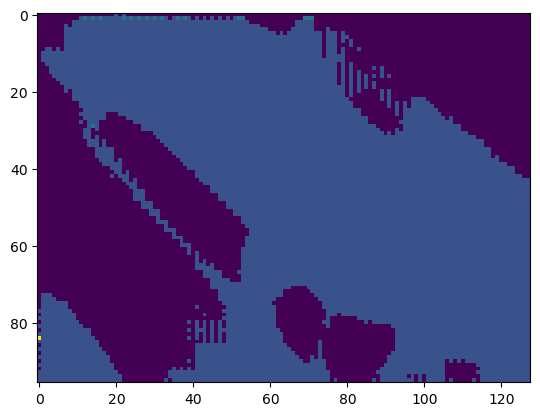

In [ ]:
plt.imshow(imagened)

In [ ]:
imagened = np.asarray(imagened, dtype='uint8')